### Data Cleaning dan EDA
- Disini akan dilakukan proses cleaning data dan exploratory data analysis (EDA) untuk memahami data.
- Cleaning yang dilakukan meliputi:
    - Pembersihan format kolom harga dan mengubah menjadi numerik
    - Pembersihan format luas bangunan,tanah serta jumlah kamar mandi dan jumlah kamar tidur menjadi numerik
    - Pembersihkan kolom lokasi dimana menghapus data properti yang lokasi aktual berada di luar medan (berastagi,lubuk pakam,dll)
    - Handling outlier dengan z-score 3 berdasarkan harga properti
    - Log transform kolom harga

In [605]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [606]:
df = pd.read_csv("..//data//dataset_properti_medan_raw_2.csv")
print(df.shape)
df.head(5)

(9346, 9)


,nama,lokasi,harga,jenis_properti,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan
0,Ruko Komersial Strategis Jual Murah,"Medan Johor, Medan","Rp 2,5 Miliar Total",Ruko,NaN,3.0,NaN,64 m²,210 m²
1,Dijual Ruko Murah Jalan Katamso Komplek Prima ...,"Medan Maimun, Medan","Rp 1,15 Miliar Total",Ruko,NaN,4.0,NaN,72 m²,192 m²
2,"Di Jual Villa Mutiara Poit, Jl. Meteorologi Vi...","Medan Tembung, Medan",Rp 900 Juta,Rumah,2,3.0,1.0,56 m²,100 m²
3,"Rumah Bagus Dipusat Kota, Harga Miring, Banyak...","Medan Baru, Medan","Rp 3,7 Miliar",Rumah,5,5.0,2.0,350 m²,300 m²
4,Ruko 3 Lantai Lokasi Sangat Strategis di H Yam...,"Medan Timur, Medan","Rp 2,8 Miliar Total",Ruko,NaN,1.0,NaN,101 m²,267 m²


In [607]:
print(df[df['jumlah_kamar_mandi'].astype(str).str.contains('m²', na=False)].shape)
print(df[df['jumlah_kamar_tidur'].astype(str).str.contains('m²', na=False)].shape)
print(df[df['garasi'].astype(str).str.contains('m²', na=False)].shape)

(0, 9)
(0, 9)
(0, 9)


In [608]:
def clean_harga(harga_str):
    if pd.isna(harga_str):
        return None
    
    harga_str = harga_str.lower().replace('rp', '').replace('total', '').replace('/m²', '').strip()
    
    harga_str = harga_str.replace(',', '.')
    
    multiplier = 1
    
    if 'miliar' in harga_str:
        multiplier = 1_000_000_000
        harga_str = harga_str.replace('miliar', '').strip()
    elif 'juta' in harga_str:
        multiplier = 1_000_000
        harga_str = harga_str.replace('juta', '').strip()
    
    try:
        angka = float(harga_str)
        return angka * multiplier
    except:
        return None

df['harga'] = df['harga'].apply(clean_harga)
df.head(5)

,nama,lokasi,harga,jenis_properti,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan
0,Ruko Komersial Strategis Jual Murah,"Medan Johor, Medan",2.500000e+09,Ruko,NaN,3.0,NaN,64 m²,210 m²
1,Dijual Ruko Murah Jalan Katamso Komplek Prima ...,"Medan Maimun, Medan",1.150000e+09,Ruko,NaN,4.0,NaN,72 m²,192 m²
2,"Di Jual Villa Mutiara Poit, Jl. Meteorologi Vi...","Medan Tembung, Medan",9.000000e+08,Rumah,2,3.0,1.0,56 m²,100 m²
3,"Rumah Bagus Dipusat Kota, Harga Miring, Banyak...","Medan Baru, Medan",3.700000e+09,Rumah,5,5.0,2.0,350 m²,300 m²
4,Ruko 3 Lantai Lokasi Sangat Strategis di H Yam...,"Medan Timur, Medan",2.800000e+09,Ruko,NaN,1.0,NaN,101 m²,267 m²


In [609]:
def clean_luas_jumlah(luas):
    if pd.isna(luas):
        return None
    luas = str(luas).lower().strip()
    
    if luas == 'studio':
        return 1  
    
    luas = luas.replace('m²', '').strip()
    
    try:
        return float(luas)
    except ValueError:
        return None
    
df['luas_bangunan'] = df['luas_bangunan'].apply(clean_luas_jumlah)
df['luas_tanah'] = df['luas_tanah'].apply(clean_luas_jumlah)
df['jumlah_kamar_tidur'] = df['jumlah_kamar_tidur'].apply(clean_luas_jumlah)
df['jumlah_kamar_mandi'] = df['jumlah_kamar_mandi'].apply(clean_luas_jumlah)

In [610]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama                9346 non-null   object 
 1   lokasi              9346 non-null   object 
 2   harga               9344 non-null   float64
 3   jenis_properti      9346 non-null   object 
 4   jumlah_kamar_tidur  6598 non-null   float64
 5   jumlah_kamar_mandi  8600 non-null   float64
 6   garasi              3587 non-null   float64
 7   luas_tanah          8848 non-null   float64
 8   luas_bangunan       9339 non-null   float64
dtypes: float64(6), object(3)
memory usage: 657.3+ KB


In [611]:
print(f"Jumlah kamar tidur: \n{df[df['jumlah_kamar_tidur'].isna()]['jenis_properti'].value_counts()}\n")
print(f"Jumlah kamar mandi: \n{df[df['jumlah_kamar_mandi'].isna()]['jenis_properti'].value_counts()}\n")
print(f"Jumlah garasi: \n{df[df['garasi'].isna()]['jenis_properti'].value_counts()}\n")

Jumlah kamar tidur: 
jenis_properti
Ruko         2329
Rumah         406
Apartemen      13
Name: count, dtype: int64

Jumlah kamar mandi: 
jenis_properti
Ruko         387
Rumah        348
Apartemen     11
Name: count, dtype: int64

Jumlah garasi: 
jenis_properti
Rumah        3251
Ruko         2014
Apartemen     494
Name: count, dtype: int64



In [612]:
print(f"luas bangunan: \n{df[df['luas_bangunan'].isna()]['jenis_properti'].value_counts()}\n")
print(f"luas tanah: \n{df[df['luas_tanah'].isna()]['jenis_properti'].value_counts()}\n")

luas bangunan: 
jenis_properti
Ruko     4
Rumah    3
Name: count, dtype: int64

luas tanah: 
jenis_properti
Apartemen    494
Ruko           3
Rumah          1
Name: count, dtype: int64



In [613]:
print(df['jenis_properti'][df['luas_tanah'].isna()].unique())
df['jumlah_kamar_tidur'] = df['jumlah_kamar_tidur'].fillna(0)
df['jumlah_kamar_mandi'] = df['jumlah_kamar_mandi'].fillna(0)
df['garasi'] = df['garasi'].fillna(0)
df['luas_tanah'] = df['luas_tanah'].fillna(df['luas_bangunan'])
df['luas_bangunan']=df['luas_bangunan'].fillna(df['luas_tanah'])

['Apartemen' 'Ruko' 'Rumah']


In [614]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama                9346 non-null   object 
 1   lokasi              9346 non-null   object 
 2   harga               9344 non-null   float64
 3   jenis_properti      9346 non-null   object 
 4   jumlah_kamar_tidur  9346 non-null   float64
 5   jumlah_kamar_mandi  9346 non-null   float64
 6   garasi              9346 non-null   float64
 7   luas_tanah          9344 non-null   float64
 8   luas_bangunan       9344 non-null   float64
dtypes: float64(6), object(3)
memory usage: 657.3+ KB


In [615]:
df.dropna(inplace=True)

In [616]:
df['lokasi'].value_counts()

lokasi
Medan Sunggal, Medan       1078
Medan Helvetia, Medan       845
Medan Timur, Medan          844
Medan Johor, Medan          766
Medan Tembung, Medan        723
Medan Barat, Medan          676
Medan Kota, Medan           614
Medan Selayang, Medan       593
Medan Perjuangan, Medan     439
Medan Area, Medan           403
Medan Petisah, Medan        390
Medan Polonia, Medan        311
Medan Baru, Medan           266
Medan Denai, Medan          260
Medan Maimun, Medan         226
Medan Tuntungan, Medan      197
Medan Amplas, Medan         172
Medan Deli, Medan           149
Medan Marelan, Medan        127
Marelan, Medan              120
Johor, Medan                 55
Medan Labuhan, Medan         29
Padang Bulan, Medan          22
Tanjung Morawa, Medan        15
Medan Belawan, Medan          9
Lubuk Pakam, Medan            5
Brastagi, Medan               5
Mariendal, Medan              3
Name: count, dtype: int64

In [617]:
not_medan = ['Tanjung Morawa, Medan','Lubuk Pakam, Medan','Brastagi, Medan','Mariendal, Medan']
df = df[~df['lokasi'].isin(not_medan)]

medan_replace = {'Johor, Medan':'Medan Johor, Medan',
                 'Marelan, Medan':'Medan Marelan, Medan',
                 'Padang Bulan, Medan':'Medan Baru, Medan'}
df['lokasi'].replace(medan_replace,inplace=True)

print(f"Jumlah kecamatan: {len(df['lokasi'].unique())}")
df['lokasi'].value_counts()

Jumlah kecamatan: 21


C:\Users\Sanju\AppData\Local\Temp\ipykernel_33156\2728083728.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['lokasi'].replace(medan_replace,inplace=True)


lokasi
Medan Sunggal, Medan       1078
Medan Helvetia, Medan       845
Medan Timur, Medan          844
Medan Johor, Medan          821
Medan Tembung, Medan        723
Medan Barat, Medan          676
Medan Kota, Medan           614
Medan Selayang, Medan       593
Medan Perjuangan, Medan     439
Medan Area, Medan           403
Medan Petisah, Medan        390
Medan Polonia, Medan        311
Medan Baru, Medan           288
Medan Denai, Medan          260
Medan Marelan, Medan        247
Medan Maimun, Medan         226
Medan Tuntungan, Medan      197
Medan Amplas, Medan         172
Medan Deli, Medan           149
Medan Labuhan, Medan         29
Medan Belawan, Medan          9
Name: count, dtype: int64

In [618]:
df['tanah_per_m2'] = df['harga']/df['luas_tanah']
df['total_ruangan'] = df['jumlah_kamar_mandi']+df['jumlah_kamar_tidur']+df['garasi']
df.head()

,nama,lokasi,harga,jenis_properti,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan,tanah_per_m2,total_ruangan
0,Ruko Komersial Strategis Jual Murah,"Medan Johor, Medan",2.500000e+09,Ruko,0.0,3.0,0.0,64.0,210.0,3.906250e+07,3.0
1,Dijual Ruko Murah Jalan Katamso Komplek Prima ...,"Medan Maimun, Medan",1.150000e+09,Ruko,0.0,4.0,0.0,72.0,192.0,1.597222e+07,4.0
2,"Di Jual Villa Mutiara Poit, Jl. Meteorologi Vi...","Medan Tembung, Medan",9.000000e+08,Rumah,2.0,3.0,1.0,56.0,100.0,1.607143e+07,6.0
3,"Rumah Bagus Dipusat Kota, Harga Miring, Banyak...","Medan Baru, Medan",3.700000e+09,Rumah,5.0,5.0,2.0,350.0,300.0,1.057143e+07,12.0
4,Ruko 3 Lantai Lokasi Sangat Strategis di H Yam...,"Medan Timur, Medan",2.800000e+09,Ruko,0.0,1.0,0.0,101.0,267.0,2.772277e+07,1.0


In [619]:
from scipy import stats

df['harga'] = np.log1p(df['harga'])
df['luas_bangunan'] = np.log1p(df['luas_bangunan'])
df['luas_tanah'] = np.log1p(df['luas_tanah'])
df['tanah_per_m2'] = np.log1p(df['tanah_per_m2'])
df['total_ruangan'] = np.log1p(df['total_ruangan'])

# Hitung z-score
z_scores_harga = stats.zscore(df['harga'])
z_scores_lb = stats.zscore(df['luas_bangunan'])
z_scores_lt = stats.zscore(df['luas_tanah'])
z_scores_jkm = stats.zscore(df['jumlah_kamar_mandi'])
z_scores_tpm = stats.zscore(df['tanah_per_m2'])
z_scores_tr = stats.zscore(df['total_ruangan'])

threshold = 1.75

# Mask outlier
mask_harga = np.abs(z_scores_harga) > threshold
mask_lb = np.abs(z_scores_lb) > threshold
mask_lt = np.abs(z_scores_lt) > threshold
mask_jkm = np.abs(z_scores_jkm) > threshold
mask_tpm = np.abs(z_scores_tpm) > threshold
mask_tr = np.abs(z_scores_tr) > threshold

combined_mask = mask_harga | mask_lb | mask_lt | mask_jkm | mask_tpm | mask_tr

# Ambil baris outlier
outliers = df[combined_mask]

print(f"Jumlah baris outlier: {outliers.shape[0]}")


Jumlah baris outlier: 1927


In [620]:
df = df.drop(outliers.index)
df.drop('nama',axis=1,inplace=True)

In [621]:
df.describe()

,harga,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan,tanah_per_m2,total_ruangan
count,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000
mean,20.928022,2.199404,2.498849,0.478814,4.615900,4.858896,16.323184,1.748215
std,0.702132,1.579351,1.133801,0.655274,0.485361,0.584445,0.608086,0.388797
min,19.328939,0.000000,0.000000,0.000000,3.496508,3.663562,14.914123,0.693147
25%,20.394762,1.000000,2.000000,0.000000,4.290459,4.418841,15.906787,1.386294
50%,20.888780,2.000000,2.000000,0.000000,4.510860,4.820282,16.327325,1.791759
75%,21.416413,3.000000,3.000000,1.000000,4.897840,5.283204,16.772022,2.079442
max,22.863332,12.000000,8.000000,10.000000,6.047372,6.336826,17.784692,2.772589


In [622]:
df.to_csv("..//data//clean.csv",index= False)

In [623]:
import sys
sys.path.append(r'c:\\Users\\Sanju\\OneDrive\\Documents\\DataScientist\\3-PORTOFOLIO\\TrenHargaRumah')
from src.utils import hist_box_plot, bar_plot, heatmap, cramers_v,violin_plot,scatter_plot

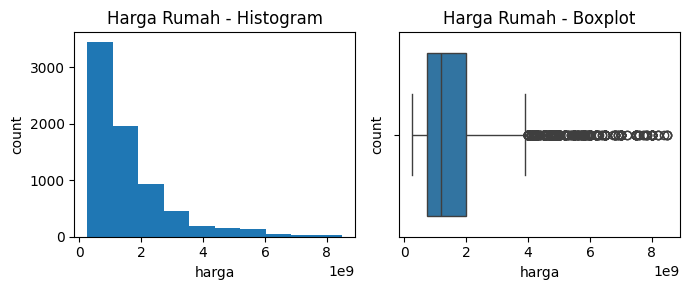

In [624]:
harga_expm1 = np.expm1(df['harga'])
hist_box_plot(harga_expm1, title='Harga Rumah', xlabel='harga', ylabel='count',figx=7,figy=3)


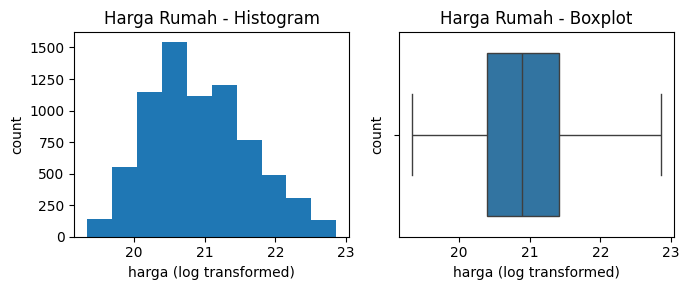

In [625]:
harga_log1p = np.log1p(harga_expm1)
hist_box_plot(harga_log1p, title='Harga Rumah', xlabel='harga (log transformed)', ylabel='count',figx=7,figy=3)

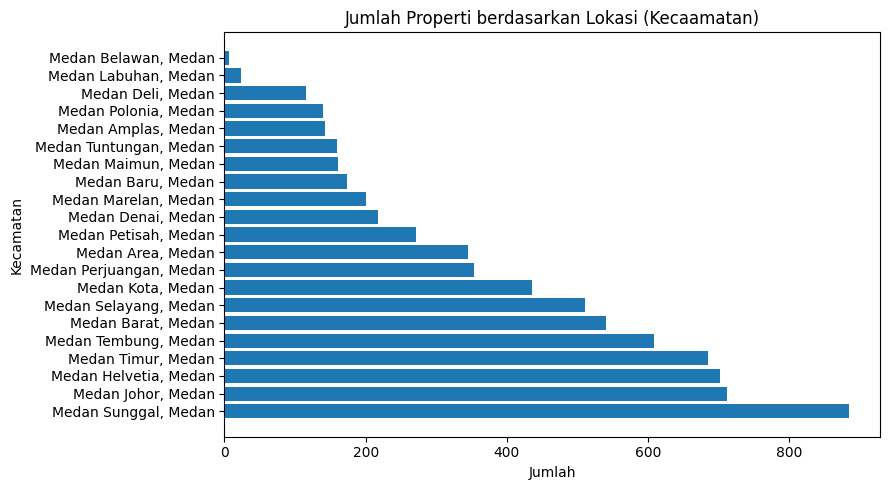

In [626]:
bar_plot(df['lokasi'],figx=9,figy=5,horizontal=True,title='Jumlah Properti berdasarkan Lokasi (Kecaamatan)',xlabel='Jumlah',ylabel='Kecamatan')

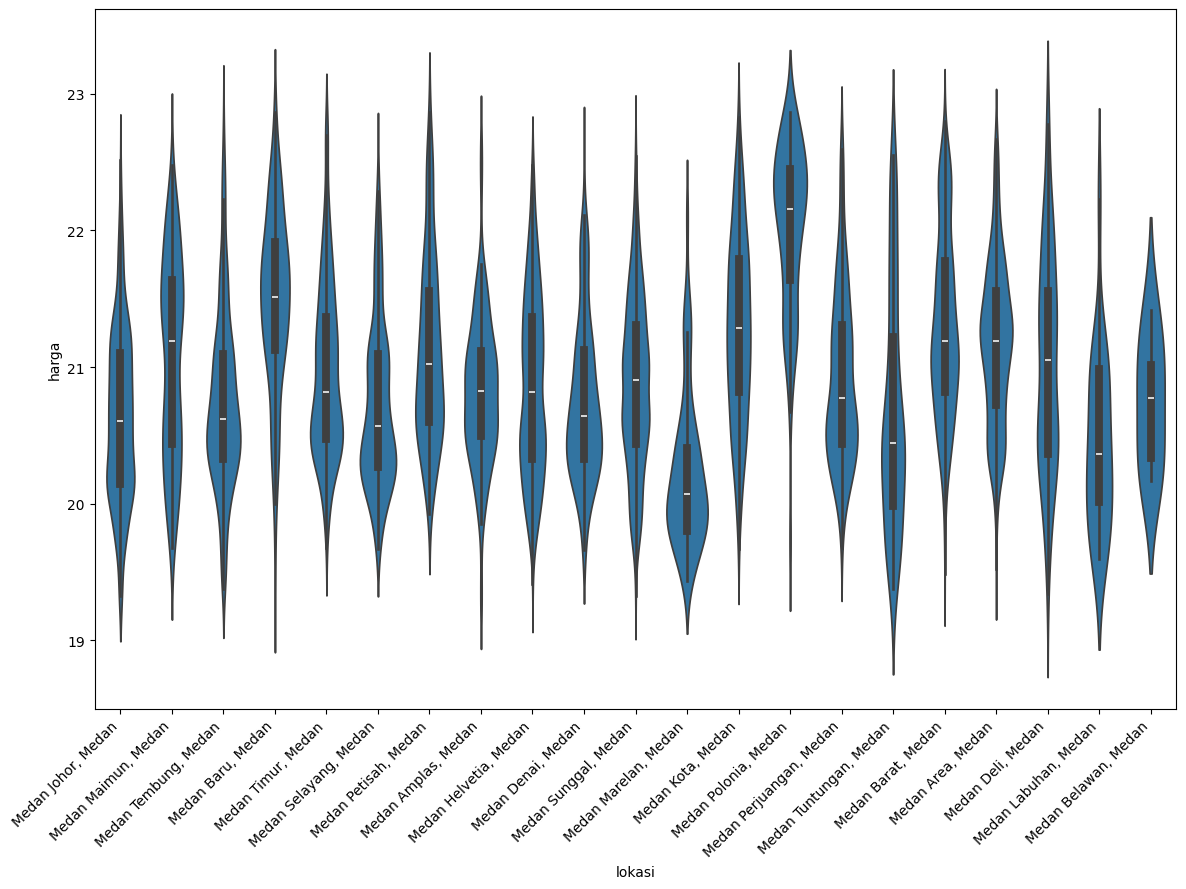

In [627]:
violin_plot(x='lokasi',y='harga',data=df,figx=12,figy=9)

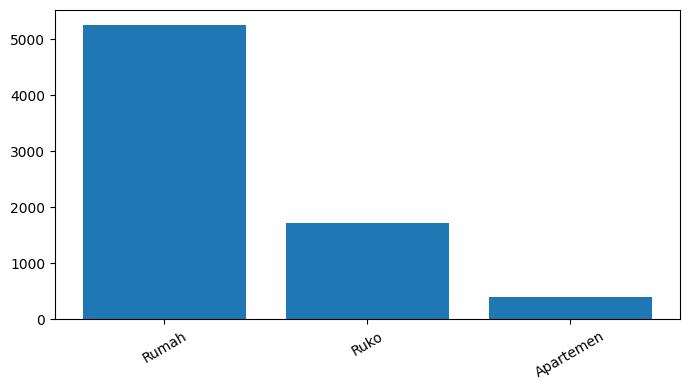

In [628]:
bar_plot(df['jenis_properti'],figx=7,figy=4)

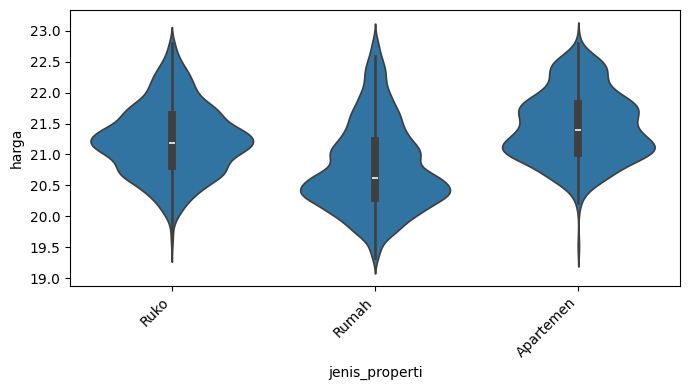

In [629]:
violin_plot(x='jenis_properti',y='harga',data=df,figx=7,figy=4)

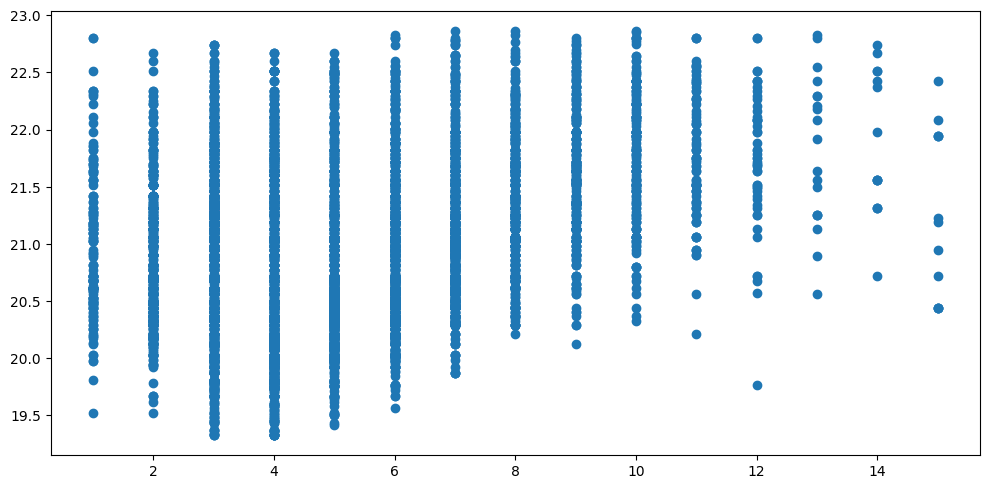

In [630]:
scatter_plot(df['jumlah_kamar_tidur']+df['jumlah_kamar_mandi']+df['garasi'],df['harga'],figx=10,figy=5)

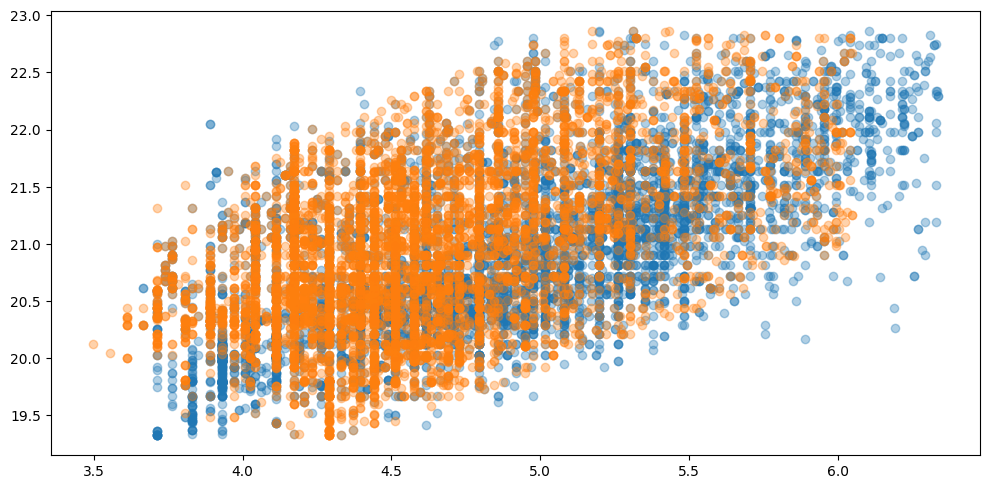

In [631]:
plt.figure(figsize=(10, 5))
plt.scatter(df['luas_bangunan'], df['harga'],alpha=.35)
plt.scatter(df['luas_tanah'], df['harga'],alpha=.35)
plt.tight_layout()
plt.show()


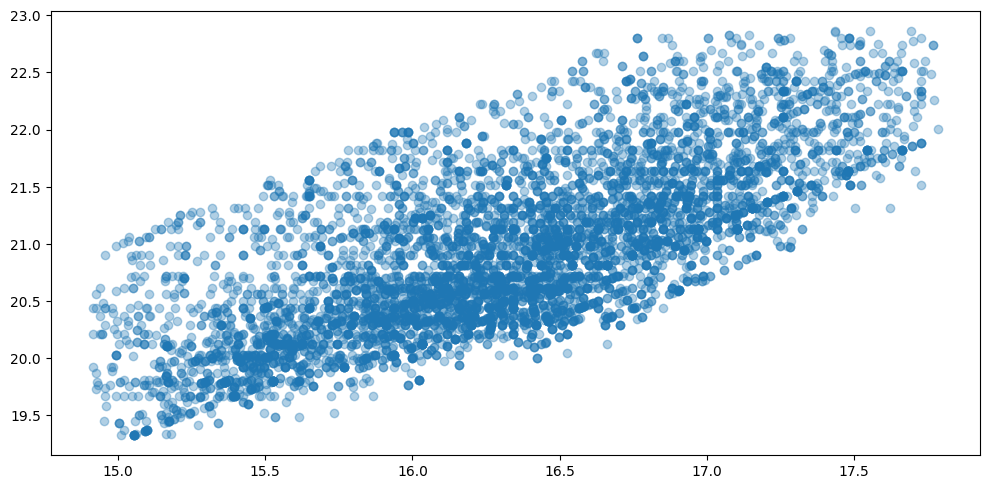

In [635]:
plt.figure(figsize=(10, 5))
plt.scatter(df['tanah_per_m2'], df['harga'],alpha=.35)
plt.tight_layout()
plt.show()

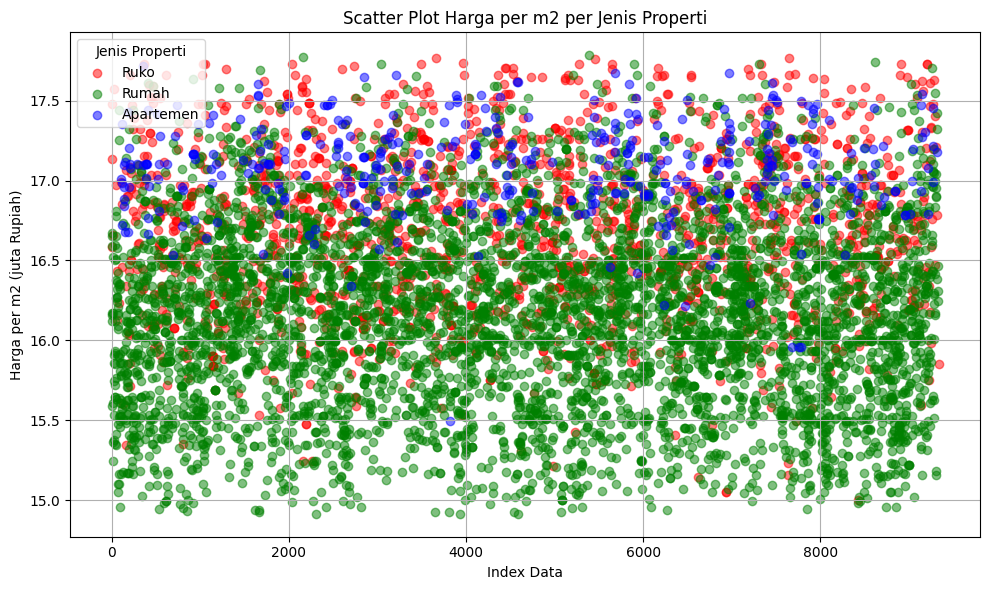

In [642]:
import matplotlib.pyplot as plt

categories = df['jenis_properti'].unique()
colors = ['red', 'green', 'blue']

plt.figure(figsize=(10, 6))

for i, cat in enumerate(categories):
    subset = df[df['jenis_properti'] == cat]
    plt.scatter(subset.index, subset['tanah_per_m2'], 
                alpha=0.5, label=cat, color=colors[i % len(colors)])

plt.title('Scatter Plot Harga per m2 per Jenis Properti')
plt.xlabel('Index Data')
plt.ylabel('Harga per m2 (juta Rupiah)')
plt.legend(title='Jenis Properti')
plt.grid(True)
plt.tight_layout()
plt.show()

In [634]:
df.corr(numeric_only=True)

,harga,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan,tanah_per_m2,total_ruangan
harga,1.000000,0.060703,0.557536,-0.037782,0.528165,0.652721,0.729283,0.238632
jumlah_kamar_tidur,0.060703,1.000000,0.219660,0.218569,0.372164,0.021932,-0.229570,0.830896
jumlah_kamar_mandi,0.557536,0.219660,1.000000,0.004477,0.376766,0.566345,0.340278,0.597104
garasi,-0.037782,0.218569,0.004477,1.000000,0.149633,-0.033766,-0.164126,0.414907
luas_tanah,0.528165,0.372164,0.376766,0.149633,1.000000,0.513817,-0.195808,0.427256
luas_bangunan,0.652721,0.021932,0.566345,-0.033766,0.513817,1.000000,0.339810,0.217816
tanah_per_m2,0.729283,-0.229570,0.340278,-0.164126,-0.195808,0.339810,1.000000,-0.068636
total_ruangan,0.238632,0.830896,0.597104,0.414907,0.427256,0.217816,-0.068636,1.000000


### Insight EDA:
- Harga properti sangat right skewed dimana terdapat beberapa properti dengan nilai fantastis yang sangat jauh lebih tinggi dibanding properti lain
- Lokasi properti paling banyak berada di medan sunggal,diikuti dengan medan timur,helvetia dan johor
- Dari violin plot, medan polonia memiliki median harga properti paling tinggi
- Dari data yang didapat, sebagian besar properti merupakan rumah lalu ruko dan terakhir apartemen
- Dari visualisasi scatter, terdapat tren dimana semakin besar luas tanah atau luas bangunan, harga ikut semakin tinggi 